## Dinucleotides and dipeptides

We counted the occurrence of individual nucleotides in the genome and residues in the proteome.

In real biological sequences, adjacent positions are rarely independent. We now have ways to talk about these sort of inter-dependencies using probabilities.

We'll start by counting adjacent pairs of nucleotides in the genome. When a sequence has $N$ bases, it has $N-1$ adjacent pairs: $0$ and $1$, $1$ and $2$, $2$ and $3$, and so forth all the way to $N-2$, $N-1$.

An easy way to get a pandas `Series` of these adjacent pairs is to:
1. create a Series of first nucleotides in a pair
2. create a Series of second nucleotides in a pair
3. add together these two series

We'll see how this works on a test string
```
alphabet='abcdefghijklmnopqrstuvwxyz'
```

In [1]:
import pandas as pd
alphabet='abcdefghijklmnopqrstuvwxyz'
first_letters = pd.Series(list(alphabet[0:-1]))
second_letters = pd.Series(list(alphabet[1:]))
pairs = first_letters + second_letters
pairs

0     ab
1     bc
2     cd
3     de
4     ef
5     fg
6     gh
7     hi
8     ij
9     jk
10    kl
11    lm
12    mn
13    no
14    op
15    pq
16    qr
17    rs
18    st
19    tu
20    uv
21    vw
22    wx
23    xy
24    yz
dtype: object

### Yeast proteome dipeptides
First we need to import the `Bio.SeqIO` module from `biopython` so we can read in our yeast sequences.

In [2]:
from Bio import SeqIO

Then we need to import the `pandas` module for our `Series` and `DataFrame` types, and the `matplotlib.pyplot` module to make graphs.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 

Here is a copy of our code to
1. Create `proteins` as an iterator over all the protein sequences
2. Create an empty `Series` of amino acid counts
3. Loop over each protein
    1. Count the nubmer of residues in that one protein
    1. Add that residue count to the running tally
5. Print the sorted version of our count series
6. Plot a bar graph of our counts

*      6064.0
W     30592.0
C     37287.0
M     61220.0
H     63795.0
Y     99429.0
Q    116054.0
P    128629.0
F    130264.0
R    130554.0
G    146138.0
A    161450.0
V    163368.0
D    171556.0
T    173814.0
N    180883.0
E    191723.0
I    192717.0
K    215733.0
S    264092.0
L    279435.0
dtype: float64


<AxesSubplot:>

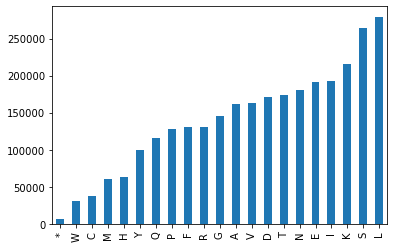

In [4]:
proteins = SeqIO.parse("../S288C_R64-3-1/orf_trans_R64-3-1_20210421.fasta", "fasta")
total_counts = pd.Series(dtype='int64')

for protein in proteins:
    protein_counts = pd.Series(list(protein.seq)).value_counts()
    total_counts = total_counts.add(protein_counts, fill_value=0)
print(total_counts.sort_values())
total_counts.sort_values().plot(kind='bar')

### Dipeptides

Now we'll use the approach above to count every adjacent pair of amino acids.

We'll make a series of first amino acids in `first_aas`, a series of second amino acids in `second_aas`, and then combine them to count them.

In [5]:
proteins = SeqIO.parse("../S288C_R64-3-1/orf_trans_R64-3-1_20210421.fasta", "fasta")
total_counts = pd.Series(dtype='int64')

for protein in proteins:
    first_aas = pd.Series(list(protein.seq[0:-1]))
    second_aas = pd.Series(list(protein.seq[1:]))
    protein_counts = (first_aas + second_aas).value_counts()
    total_counts = total_counts.add(protein_counts, fill_value=0)

In [6]:
total_counts.sort_values()

*E        1.0
*F        1.0
*Y        1.0
*K        1.0
*M        1.0
       ...   
LK    21887.0
LS    24445.0
SL    24535.0
LL    27655.0
SS    31531.0
Length: 437, dtype: float64

#### Probabilities

Convert the counts to probabilities in a variable `dipep_probs` by 
1. Using the `.sum()` method to find the total number of amino acid pairs counted
2. Dividing the `total_counts` series by this sum to get "normalized" probabilities

In [8]:
total_counts.sum()

2938763.0

In [11]:
dipep_probs = total_counts / total_counts.sum()
dipep_probs
dipep_probs["SS"]

0.01072934428533366

#### Marginal probabilities

The table of amino acid _pair_ probabilities give the _joint_ distribution.

There are two way to compute the _marginal_ probability of an `A`. We can count every time an `A` shows up in the first position, and we can count every time an `A` shows up in the second position.

Compute this both ways and compare it to the value we got from the single-nucleotide counting above.

In [24]:
dipep_probs[dipep_probs.index.str.startswith('A')].sum()

0.054938081090581306

In [26]:
# dipep_probs[dipep_probs.index.str.endswith('A')].sum()
dipep_probs

**    1.020838e-06
*A    6.805585e-07
*E    3.402792e-07
*F    3.402792e-07
*G    6.805585e-07
          ...     
YS    2.690588e-03
YT    1.836827e-03
YV    1.879362e-03
YW    3.967656e-04
YY    1.449930e-03
Length: 437, dtype: float64

Compute all of the marginal probabilities. 

There are many reasonable ways to approach this -- one is to use a for loop

W    0.010410
C    0.012688
M    0.020832
H    0.021708
Y    0.033834
Q    0.039491
P    0.043770
F    0.044326
R    0.044425
G    0.049728
A    0.054938
V    0.055591
D    0.058377
T    0.059145
N    0.061551
E    0.065239
I    0.065577
K    0.073409
S    0.089865
L    0.095086
dtype: float64


<AxesSubplot:>

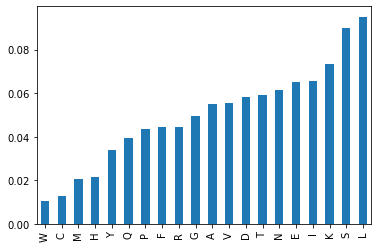

In [48]:
marginal_probs = pd.Series(dtype="float64")

for aa in list("ACDEFGHIKLMNPQRSTVWY"):
    aa_prob = dipep_probs[dipep_probs.index.str.startswith(aa)].sum()
    aa_prob = pd.Series([aa_prob], index=[aa])
    marginal_probs = marginal_probs.combine_first(aa_prob)
print(marginal_probs.sort_values())
marginal_probs.sort_values().plot(kind='bar')

#### Conditional probabilities

Compute the _conditional_ probability of a `C` following a first `A`. Is this higher or lower than the unconditional (marginal) probability of a `C`?

In [51]:
cond_CA = dipep_probs["AC"] / marginal_probs["A"]
print(cond_CA, marginal_probs["C"])

0.013341591824094147 0.01268799151207498


Another way of looking at this is to compute the ratio `P(CA) / (P(C) * P(A))`, which is the ratio between the observed dinucleotide probability and the expected dinucleotide probabilty under the assumption of independence.

In [52]:
dipep_probs["AC"] / (marginal_probs["A"] * marginal_probs["C"])

1.0515132999101666

### _Exercise_ 

The file `../S288C_R64-3-1/S288C_reference_sequence_R64-3-1_20210421.fsa` has the nucleotide sequence of the yeast genome. Each chromosome has its own sequence entry. 

Count the dinucleotide frequencies in the genome.

In [55]:
chroms = SeqIO.parse("../S288C_R64-3-1/S288C_reference_sequence_R64-3-1_20210421.fsa", "fasta")
total_counts = pd.Series(dtype='int64')

for chrom in chroms:
    first_nts = pd.Series(list(chrom.seq[0:-1]))
    second_nts = pd.Series(list(chrom.seq[1:]))
    chrom_counts = (first_nts + second_nts).value_counts()
    total_counts = total_counts.add(chrom_counts, fill_value=0)

Use the dinucleotide frequencies to compute dinucleotide probabilities in a variable named `dint_probs`.

In [58]:
dint_probs = total_counts / total_counts.sum()
dint_probs

AA    0.108657
AC    0.052599
AG    0.058307
AT    0.090245
CA    0.064685
CC    0.038959
CG    0.029226
CT    0.058012
GA    0.062189
GC    0.037294
GG    0.038705
GT    0.052408
TA    0.074275
TC    0.062030
TG    0.064359
TT    0.108050
dtype: float64

Compute the marginal probabilities of each nucleotide in a variable called `marginal_probs`.

G    0.190596
C    0.190883
T    0.308715
A    0.309807
dtype: float64


<AxesSubplot:>

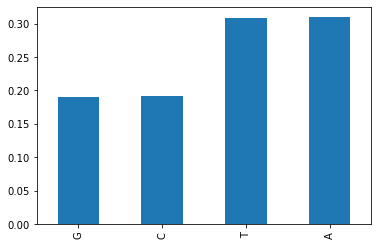

In [60]:
marginal_probs = pd.Series(dtype="float64")

for nt in list("ACGT"):
    nt_prob = dint_probs[dint_probs.index.str.startswith(nt)].sum()
    nt_prob = pd.Series([nt_prob], index=[nt])
    marginal_probs = marginal_probs.combine_first(nt_prob)
print(marginal_probs.sort_values())
marginal_probs.sort_values().plot(kind='bar')

Determine the _conditional_ probability of a `G` base following a `C` base. How does this compare to the overall probability of a `G` base?

In [62]:
dint_probs["CG"] / marginal_probs["C"]

0.15310810764224056